# 因子分析工具 - 全因子计算

## 功能说明
- 输入指定时间范围和股票代码
- 使用akshare获取A股日线数据
- 计算quantlib.research中的全部因子
- 输出完整的因子DataFrame用于后续分析

## 使用方法
1. 设置参数：股票代码、开始日期、结束日期
2. 运行所有单元格
3. 获得包含所有因子的DataFrame

In [2]:
# 导入必要的库
import sys
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# 添加项目路径
project_path = os.path.dirname(os.getcwd()) if 'scripts' in os.getcwd() else os.getcwd()
if project_path not in sys.path:
    sys.path.append(project_path)

print(f"当前工作目录: {os.getcwd()}")
print(f"项目路径: {project_path}")

当前工作目录: d:\projects\q\myQ
项目路径: d:\projects\q\myQ


In [3]:
# 导入数据获取和分析模块
try:
    # 导入akshare用于数据获取
    import akshare as ak
    print("✅ akshare导入成功")
    
    # 导入quantlib研究模块
    from quantlib.research.factor_library import create_factor_library, FactorCategory
    from quantlib.research.factor_analyzer import FactorAnalyzer
    print("✅ quantlib研究模块导入成功")
    
except ImportError as e:
    print(f"❌ 模块导入失败: {e}")
    print("请确保akshare和quantlib已正确安装")
    print("安装命令: pip install akshare")

✅ akshare导入成功
✅ quantlib研究模块导入成功


## 📋 参数设置
在这里设置你要分析的股票代码和时间范围

In [4]:
# ===== 用户参数设置 =====
# 股票代码 (akshare格式: sh/sz + 6位代码)
STOCK_CODE = "sh601899"  # 紫金矿业，可修改为其他股票代码
# 常用代码示例:
# sh601899 - 紫金矿业
# sz000001 - 平安银行  
# sh600519 - 贵州茅台
# sz000858 - 五粮液

# 时间范围 (格式: YYYYMMDD)
START_DATE = "20240920"  # 开始日期
END_DATE = "20250923"    # 结束日期

# 数据复权设置
ADJUST = "qfq"  # 复权类型: "" 不复权, "qfq" 前复权, "hfq" 后复权

print(f"📊 分析参数:")
print(f"   股票代码: {STOCK_CODE}")
print(f"   时间范围: {START_DATE[:4]}-{START_DATE[4:6]}-{START_DATE[6:8]} 至 {END_DATE[:4]}-{END_DATE[4:6]}-{END_DATE[6:8]}")
print(f"   复权方式: {ADJUST if ADJUST else '不复权'}")

📊 分析参数:
   股票代码: sh601899
   时间范围: 2024-09-20 至 2025-09-23
   复权方式: qfq


## 📈 数据获取


In [22]:
# 获取股票日线数据
print(f"🔄 正在获取 {STOCK_CODE} 的日线数据...")

try:
    # 使用akshare获取A股日线数据
    stock_data = ak.stock_zh_a_daily(
        symbol=STOCK_CODE,
        start_date=START_DATE,
        end_date=END_DATE,
        adjust=ADJUST
    )
    
    if stock_data is None or stock_data.empty:
        raise ValueError("获取的数据为空")
    
    # 设置日期为索引
    if 'date' in stock_data.columns:
        stock_data['date'] = pd.to_datetime(stock_data['date'])
        stock_data.set_index('date', inplace=True)
    
    # 标准化列名为小写
    stock_data.columns = stock_data.columns.str.lower()
    
    print(f"✅ 数据获取成功!")
    print(f"   数据形状: {stock_data.shape}")
    print(f"   时间范围: {stock_data.index[0].strftime('%Y-%m-%d')} 至 {stock_data.index[-1].strftime('%Y-%m-%d')}")
    print(f"   数据列: {list(stock_data.columns)}")
    
    # 显示前几行数据
    print(f"\n📋 数据样本:")
    display(stock_data.head())
    
    # 数据质量检查
    print(f"\n🔍 数据质量检查:")
    print(f"   缺失值统计: {stock_data.isnull().sum().sum()} 个")
    print(f"   数据完整度: {(1 - stock_data.isnull().sum().sum() / (stock_data.shape[0] * stock_data.shape[1])) * 100:.1f}%")
    
except Exception as e:
    print(f"❌ 数据获取失败: {e}")
    print("请检查:")
    print("  1. 股票代码格式 (如: sh600519, sz000001)")
    print("  2. 日期范围格式 (如: 20240101)")
    print("  3. 网络连接")
    print("  4. akshare是否正确安装")
    stock_data = None

🔄 正在获取 sh601899 的日线数据...
✅ 数据获取成功!
   数据形状: (246, 8)
   时间范围: 2024-09-20 至 2025-09-23
   数据列: ['open', 'high', 'low', 'close', 'volume', 'amount', 'outstanding_share', 'turnover']

📋 数据样本:


,open,high,low,close,volume,amount,outstanding_share,turnover
date,,,,,,,,
2024-09-20,15.27,15.65,15.09,15.65,192733014.0,3.031916e+09,2.055629e+10,0.009376
2024-09-23,15.65,15.77,15.45,15.59,136737176.0,2.166292e+09,2.055629e+10,0.006652
2024-09-24,15.87,16.40,15.79,16.27,251226583.0,4.106644e+09,2.055629e+10,0.012221
2024-09-25,16.68,17.07,16.66,16.68,283724846.0,4.841338e+09,2.055629e+10,0.013802
2024-09-26,16.85,17.14,16.46,17.12,224564936.0,3.833087e+09,2.055629e+10,0.010924



🔍 数据质量检查:
   缺失值统计: 0 个
   数据完整度: 100.0%


## 🔧 因子库初始化
创建因子库并查看可用因子

In [23]:
# 创建因子库
print("🔧 初始化因子库...")

try:
    # 创建因子库实例
    factor_lib = create_factor_library()
    
    # 获取因子库摘要
    summary = factor_lib.get_summary()
    
    print(f"✅ 因子库创建成功!")
    print(f"   总因子数: {summary['total_factors']}")
    print(f"   因子分类: {summary['categories']}")
    
    # 获取所有因子列表
    all_factors = factor_lib.list_factors()
    
    print(f"\n📋 可用因子列表:")
    for category, factor_names in factor_lib.factor_categories.items():
        if factor_names:
            print(f"\n  {category.value.upper()} ({len(factor_names)}个):")
            for name in sorted(factor_names):
                factor = factor_lib.factors[name]
                print(f"    - {name}: {factor.description}")
                
except Exception as e:
    print(f"❌ 因子库创建失败: {e}")
    import traceback
    traceback.print_exc()
    factor_lib = None

🔧 初始化因子库...
✅ 因子库创建成功!
   总因子数: 10
   因子分类: {'technical': 7, 'value': 2, 'profitability': 1}

📋 可用因子列表:

  TECHNICAL (7个):
    - momentum_20d: 20日动量因子
    - momentum_5d: 5日动量因子
    - momentum_60d: 60日动量因子
    - rsi_14d: 14日RSI因子
    - rsi_30d: 30日RSI因子
    - volatility_20d: 20日波动率因子
    - volatility_60d: 60日波动率因子

  VALUE (2个):
    - pb_ratio: 市净率因子
    - pe_ratio: 市盈率因子

  PROFITABILITY (1个):
    - roe: ROE因子


## 🧮 计算所有因子
对获取的股票数据计算所有可用的因子

In [24]:
# 计算所有因子
if stock_data is not None:
    print(f"🧮 正在计算所有因子...")

    try:
        # 确保数据格式正确
        print(f"   数据预处理...")

        # 检查必需的列是否存在
        required_columns = ['open', 'high', 'low', 'close', 'volume']
        available_columns = [col for col in required_columns if col in stock_data.columns]
        missing_columns = [col for col in required_columns if col not in stock_data.columns]

        print(f"   可用列: {available_columns}")
        if missing_columns:
            print(f"   缺失列: {missing_columns}")

        # 创建结果DataFrame，从原始数据开始
        factor_results = stock_data.copy()

        print(f"   开始因子计算...")

        # === 1. 动量因子 ===
        print(f"   计算动量因子...")

        # 5日动量
        factor_results['factor_momentum_5d'] = stock_data['close'].pct_change(5)

        # 20日动量
        factor_results['factor_momentum_20d'] = stock_data['close'].pct_change(20)

        # 60日动量
        factor_results['factor_momentum_60d'] = stock_data['close'].pct_change(60)

        # === 2. 反转因子 ===
        print(f"   计算反转因子...")

        # 1日反转（负动量）
        factor_results['factor_reversal_1d'] = -stock_data['close'].pct_change(1)

        # 5日反转
        factor_results['factor_reversal_5d'] = -stock_data['close'].pct_change(5)

        # === 3. 波动率因子 ===
        print(f"   计算波动率因子...")

        # 计算日收益率
        returns = stock_data['close'].pct_change()

        # 20日波动率
        factor_results['factor_volatility_20d'] = returns.rolling(20).std() * np.sqrt(252)

        # 60日波动率
        factor_results['factor_volatility_60d'] = returns.rolling(60).std() * np.sqrt(252)

        # === 4. RSI因子 ===
        print(f"   计算RSI因子...")

        def calculate_rsi(prices, period=14):
            delta = prices.diff()
            gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
            rs = gain / loss
            rsi = 100 - (100 / (1 + rs))
            return rsi.fillna(50)

        # 14日RSI
        factor_results['factor_rsi_14d'] = calculate_rsi(stock_data['close'], 14)

        # 30日RSI
        factor_results['factor_rsi_30d'] = calculate_rsi(stock_data['close'], 30)

        # === 5. 移动平均因子 ===
        print(f"   计算移动平均因子...")

        # 价格相对于20日均线的位置
        ma20 = stock_data['close'].rolling(20).mean()
        factor_results['factor_ma_ratio_20d'] = stock_data['close'] / ma20 - 1

        # 价格相对于60日均线的位置
        ma60 = stock_data['close'].rolling(60).mean()
        factor_results['factor_ma_ratio_60d'] = stock_data['close'] / ma60 - 1

        # === 6. 成交量因子 ===
        print(f"   计算成交量因子...")

        # 成交量相对比率
        vol_ma20 = stock_data['volume'].rolling(20).mean()
        factor_results['factor_volume_ratio_20d'] = stock_data['volume'] / vol_ma20 - 1

        # 价量关系
        factor_results['factor_price_volume_corr_20d'] = returns.rolling(20).corr(stock_data['volume'].pct_change())

        # === 7. 价格位置因子 ===
        print(f"   计算价格位置因子...")

        # 20日内价格位置（威廉指标思想）
        high_20 = stock_data['high'].rolling(20).max()
        low_20 = stock_data['low'].rolling(20).min()
        factor_results['factor_price_position_20d'] = (stock_data['close'] - low_20) / (high_20 - low_20)

        # === 8. 振幅因子 ===
        print(f"   计算振幅因子...")

        # 日振幅
        factor_results['factor_amplitude_1d'] = (stock_data['high'] - stock_data['low']) / stock_data['close']

        # 20日平均振幅
        factor_results['factor_amplitude_20d'] = factor_results['factor_amplitude_1d'].rolling(20).mean()

        # === 9. 跳空因子 ===
        print(f"   计算跳空因子...")

        # 向上跳空
        factor_results['factor_gap_up'] = (stock_data['open'] / stock_data['close'].shift(1) - 1).clip(lower=0)

        # 向下跳空
        factor_results['factor_gap_down'] = (stock_data['open'] / stock_data['close'].shift(1) - 1).clip(upper=0)

        # === 10. 综合技术指标 ===
        print(f"   计算综合指标...")

        # 简化版MACD
        ema12 = stock_data['close'].ewm(span=12).mean()
        ema26 = stock_data['close'].ewm(span=26).mean()
        factor_results['factor_macd'] = ema12 - ema26

        print(f"✅ 因子计算完成!")
        print(f"   结果形状: {factor_results.shape}")

        # 统计因子列
        factor_columns = [col for col in factor_results.columns if col.startswith('factor_')]
        price_columns = [col for col in factor_results.columns if col in required_columns]

        print(f"   价格列数: {len(price_columns)} ({price_columns})")
        print(f"   因子列数: {len(factor_columns)}")

        # 显示因子列名
        if factor_columns:
            print(f"\n📊 计算的因子 ({len(factor_columns)}个):")
            factor_categories = {
                'momentum': [f for f in factor_columns if 'momentum' in f],
                'reversal': [f for f in factor_columns if 'reversal' in f],
                'volatility': [f for f in factor_columns if 'volatility' in f],
                'rsi': [f for f in factor_columns if 'rsi' in f],
                'ma_ratio': [f for f in factor_columns if 'ma_ratio' in f],
                'volume': [f for f in factor_columns if 'volume' in f or 'price_volume' in f],
                'position': [f for f in factor_columns if 'position' in f],
                'amplitude': [f for f in factor_columns if 'amplitude' in f],
                'gap': [f for f in factor_columns if 'gap' in f],
                'technical': [f for f in factor_columns if 'macd' in f]
            }

            for category, factors in factor_categories.items():
                if factors:
                    print(f"  {category.upper()} ({len(factors)}个): {factors}")

            # 显示基础统计信息
            print(f"\n📈 因子统计信息:")
            display(factor_results[factor_columns].describe())
        else:
            print(f"⚠️ 没有计算出因子，可能是数据格式不匹配")

    except Exception as e:
        print(f"❌ 因子计算失败: {e}")
        import traceback
        traceback.print_exc()
        factor_results = stock_data  # 至少保留原始数据

else:
    print("⚠️ 无法进行因子计算：缺少数据")
    factor_results = None

🧮 正在计算所有因子...
   数据预处理...
   可用列: ['open', 'high', 'low', 'close', 'volume']
   开始因子计算...
   计算动量因子...
   计算反转因子...
   计算波动率因子...
   计算RSI因子...
   计算移动平均因子...
   计算成交量因子...
   计算价格位置因子...
   计算振幅因子...
   计算跳空因子...
   计算综合指标...
✅ 因子计算完成!
   结果形状: (246, 27)
   价格列数: 5 (['open', 'high', 'low', 'close', 'volume'])
   因子列数: 19

📊 计算的因子 (19个):
  MOMENTUM (3个): ['factor_momentum_5d', 'factor_momentum_20d', 'factor_momentum_60d']
  REVERSAL (2个): ['factor_reversal_1d', 'factor_reversal_5d']
  VOLATILITY (2个): ['factor_volatility_20d', 'factor_volatility_60d']
  RSI (2个): ['factor_rsi_14d', 'factor_rsi_30d']
  MA_RATIO (2个): ['factor_ma_ratio_20d', 'factor_ma_ratio_60d']
  VOLUME (2个): ['factor_volume_ratio_20d', 'factor_price_volume_corr_20d']
  POSITION (1个): ['factor_price_position_20d']
  AMPLITUDE (2个): ['factor_amplitude_1d', 'factor_amplitude_20d']
  GAP (2个): ['factor_gap_up', 'factor_gap_down']
  TECHNICAL (1个): ['factor_macd']

📈 因子统计信息:


,factor_momentum_5d,factor_momentum_20d,factor_momentum_60d,factor_reversal_1d,factor_reversal_5d,factor_volatility_20d,factor_volatility_60d,factor_rsi_14d,factor_rsi_30d,factor_ma_ratio_20d,factor_ma_ratio_60d,factor_volume_ratio_20d,factor_price_volume_corr_20d,factor_price_position_20d,factor_amplitude_1d,factor_amplitude_20d,factor_gap_up,factor_gap_down,factor_macd
count,241.000000,226.000000,186.000000,245.000000,241.000000,226.000000,186.000000,246.000000,246.000000,227.000000,187.000000,227.000000,226.000000,227.000000,246.000000,227.000000,245.000000,245.000000,246.000000
mean,0.010145,0.036287,0.099759,-0.002264,-0.010145,0.317530,0.317382,54.888649,54.308126,0.016095,0.058054,0.016273,0.062281,0.550452,0.027640,0.026430,0.005264,-0.003236,0.185218
std,0.046240,0.080532,0.117845,0.020914,0.046240,0.081633,0.045300,13.377519,9.136244,0.044425,0.066915,0.361191,0.367595,0.288323,0.013548,0.005419,0.008912,0.008342,0.352038
min,-0.151397,-0.138085,-0.158192,-0.075024,-0.146889,0.211772,0.260179,20.555556,29.721362,-0.118731,-0.091783,-0.698965,-0.707312,0.000000,0.009637,0.018661,0.000000,-0.099644,-0.385647
25%,-0.022152,-0.015169,0.027799,-0.014659,-0.036514,0.265093,0.276565,48.222912,50.000000,-0.012030,0.019437,-0.246301,-0.243134,0.292889,0.018927,0.022537,0.000000,-0.003932,-0.001083
50%,0.009623,0.018624,0.095137,-0.001946,-0.009623,0.288654,0.302656,54.256669,54.399432,0.012658,0.051003,-0.045064,0.073332,0.619048,0.024504,0.024819,0.000653,0.000000,0.138951
75%,0.036514,0.085194,0.158886,0.009874,0.022152,0.330408,0.368284,64.478544,59.718330,0.040238,0.089846,0.224420,0.414626,0.791562,0.032387,0.028953,0.007389,0.000000,0.299250
max,0.146889,0.245450,0.399565,0.099051,0.151397,0.537547,0.392556,87.978142,76.198083,0.148568,0.241505,1.356743,0.745920,1.000000,0.131073,0.041859,0.082774,0.000000,1.344580


## 📊 因子数据预览
查看计算结果的详细信息

In [25]:
# 因子数据预览和分析
if factor_results is not None:
    print("📊 因子数据预览")
    
    # 基础信息
    print(f"\n基础信息:")
    print(f"  数据期间: {factor_results.index[0].strftime('%Y-%m-%d')} 至 {factor_results.index[-1].strftime('%Y-%m-%d')}")
    print(f"  交易日数: {len(factor_results)} 天")
    print(f"  总列数: {factor_results.shape[1]}")
    
    # 价格数据列
    price_columns = ['open', 'high', 'low', 'close', 'volume']
    available_price_cols = [col for col in price_columns if col in factor_results.columns]
    
    # 因子数据列
    factor_columns = [col for col in factor_results.columns if col.startswith('factor_')]
    
    print(f"\n列分布:")
    print(f"  价格数据: {len(available_price_cols)} 列 {available_price_cols}")
    print(f"  因子数据: {len(factor_columns)} 列")
    
    # 显示最近几天的数据
    print(f"\n📋 最新数据样本 (最近5天):")
    preview_columns = available_price_cols + factor_columns[:8]  # 显示前8个因子
    display(factor_results[preview_columns].tail())
    
    # 因子缺失值统计
    if factor_columns:
        print(f"\n🔍 因子数据质量检查:")
        missing_stats = factor_results[factor_columns].isnull().sum()
        missing_stats = missing_stats[missing_stats > 0].sort_values(ascending=False)
        
        if len(missing_stats) > 0:
            print(f"  存在缺失值的因子:")
            for factor, missing_count in missing_stats.items():
                missing_pct = missing_count / len(factor_results) * 100
                print(f"    {factor}: {missing_count} 个 ({missing_pct:.1f}%)")
        else:
            print(f"  ✅ 所有因子数据完整，无缺失值")
    
    # 如果没有因子，仅显示价格数据
    if not factor_columns:
        print(f"\n📋 价格数据预览 (最近5天):")
        display(factor_results[available_price_cols].tail())
        
else:
    print("⚠️ 没有可预览的数据")

📊 因子数据预览

基础信息:
  数据期间: 2024-09-20 至 2025-09-23
  交易日数: 246 天
  总列数: 27

列分布:
  价格数据: 5 列 ['open', 'high', 'low', 'close', 'volume']
  因子数据: 19 列

📋 最新数据样本 (最近5天):


,open,high,low,close,volume,factor_momentum_5d,factor_momentum_20d,factor_momentum_60d,factor_reversal_1d,factor_reversal_5d,factor_volatility_20d,factor_volatility_60d,factor_rsi_14d
date,,,,,,,,,,,,,
2025-09-17,25.12,25.29,24.75,25.07,209214970.0,-0.004369,0.219358,0.320169,0.009874,0.004369,0.444635,0.344971,67.586207
2025-09-18,24.68,25.04,24.11,24.42,263192155.0,-0.050175,0.185437,0.286617,0.025927,0.050175,0.462265,0.350550,59.128065
2025-09-19,24.42,25.15,24.42,25.02,202176273.0,-0.024561,0.211036,0.264914,-0.024570,0.024561,0.464907,0.344270,54.819277
2025-09-22,25.50,25.56,24.85,25.37,194423251.0,-0.005098,0.142278,0.301026,-0.013989,0.005098,0.397281,0.342705,56.896552
2025-09-23,25.60,26.38,25.25,25.82,276108202.0,0.019747,0.153193,0.297487,-0.017737,-0.019747,0.399113,0.342202,56.395349



🔍 因子数据质量检查:
  存在缺失值的因子:
    factor_momentum_60d: 60 个 (24.4%)
    factor_volatility_60d: 60 个 (24.4%)
    factor_ma_ratio_60d: 59 个 (24.0%)
    factor_volatility_20d: 20 个 (8.1%)
    factor_momentum_20d: 20 个 (8.1%)
    factor_price_volume_corr_20d: 20 个 (8.1%)
    factor_ma_ratio_20d: 19 个 (7.7%)
    factor_price_position_20d: 19 个 (7.7%)
    factor_amplitude_20d: 19 个 (7.7%)
    factor_volume_ratio_20d: 19 个 (7.7%)
    factor_momentum_5d: 5 个 (2.0%)
    factor_reversal_5d: 5 个 (2.0%)
    factor_reversal_1d: 1 个 (0.4%)
    factor_gap_up: 1 个 (0.4%)
    factor_gap_down: 1 个 (0.4%)


## 💾 数据保存
将计算结果保存到本地文件供后续分析使用

In [27]:
# 保存因子数据
if factor_results is not None:
    # 生成文件名
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    # 从股票代码中提取数字部分
    stock_num = STOCK_CODE[-6:] if len(STOCK_CODE) >= 6 else STOCK_CODE
    filename = f"factor_data_{stock_num}_{START_DATE}_{END_DATE}_{timestamp}.csv"
    filepath = os.path.join("data", filename)
    
    # 确保data目录存在
    os.makedirs("data", exist_ok=True)
    
    try:
        # 保存为CSV
        factor_results.to_csv(filepath)
        
        print(f"💾 数据保存成功!")
        print(f"   文件路径: {filepath}")
        print(f"   文件大小: {os.path.getsize(filepath) / 1024:.1f} KB")
        
        # 保存元数据信息
        factor_columns = [col for col in factor_results.columns if col.startswith('factor_')]
        metadata = {
            'stock_code': STOCK_CODE,
            'stock_number': stock_num,
            'start_date': START_DATE,
            'end_date': END_DATE,
            'adjust_type': ADJUST,
            'total_days': len(factor_results),
            'total_factors': len(factor_columns),
            'factor_list': factor_columns,
            'created_time': datetime.now().isoformat(),
            'columns': list(factor_results.columns),
            'data_source': 'akshare',
            'data_quality': {
                'missing_values': int(factor_results.isnull().sum().sum()),
                'completeness_pct': float((1 - factor_results.isnull().sum().sum() / (factor_results.shape[0] * factor_results.shape[1])) * 100)
            }
        }
        
        metadata_file = filepath.replace('.csv', '_metadata.json')
        import json
        with open(metadata_file, 'w', encoding='utf-8') as f:
            json.dump(metadata, f, indent=2, ensure_ascii=False)
        
        print(f"   元数据: {metadata_file}")
        
    except Exception as e:
        print(f"❌ 数据保存失败: {e}")
        
else:
    print("⚠️ 没有数据可保存")

💾 数据保存成功!
   文件路径: data\factor_data_601899_20240920_20250923_20250928_153532.csv
   文件大小: 104.3 KB
   元数据: data\factor_data_601899_20240920_20250923_20250928_153532_metadata.json


## 📋 使用总结
总结本次分析的结果和后续建议

In [ ]:
# 分析总结
print("📋 ===== 因子分析总结 =====")
print(f"\n✅ 任务完成情况:")

if factor_results is not None:
    factor_columns = [col for col in factor_results.columns if col.startswith('factor_')]
    
    print(f"  ✓ 数据获取: 成功 (akshare)")
    print(f"  ✓ 因子计算: {'成功' if factor_columns else '部分成功 (仅价格数据)'}")
    print(f"  ✓ 数据保存: 成功")
    
    print(f"\n📊 分析结果:")
    print(f"  股票代码: {STOCK_CODE}")
    print(f"  分析期间: {START_DATE[:4]}-{START_DATE[4:6]}-{START_DATE[6:8]} 至 {END_DATE[:4]}-{END_DATE[4:6]}-{END_DATE[6:8]}")
    print(f"  复权方式: {ADJUST if ADJUST else '不复权'}")
    print(f"  交易天数: {len(factor_results)} 天")
    print(f"  计算因子: {len(factor_columns)} 个")
    
    print(f"\n🔧 数据质量:")
    missing_count = factor_results.isnull().sum().sum()
    total_values = factor_results.shape[0] * factor_results.shape[1]
    completeness = (1 - missing_count / total_values) * 100
    print(f"  数据完整度: {completeness:.1f}%")
    print(f"  缺失值: {missing_count} / {total_values}")
    
    print(f"\n📈 后续分析建议:")
    print(f"  1. 因子相关性分析: 检查因子间的相关性")
    print(f"  2. 因子有效性测试: 计算IC值和IR值")
    print(f"  3. 因子组合策略: 基于有效因子构建投资策略")
    print(f"  4. 回测验证: 验证因子策略的历史表现")
    print(f"  5. 风险分析: 评估因子暴露和风险贡献")
    
    print(f"\n💡 使用建议:")
    print(f"  • 因子数据已保存到 data/ 目录")
    print(f"  • 可以直接使用 pd.read_csv() 加载数据")
    print(f"  • 建议使用quantlib.research.factor_analyzer进行深入分析")
    print(f"  • akshare数据质量较好，适合A股分析")
    
else:
    print(f"  ✗ 数据获取: 失败")
    print(f"  ✗ 因子计算: 未完成")
    print(f"  ✗ 数据保存: 未完成")
    
    print(f"\n🔧 问题排查:")
    print(f"  1. 检查网络连接")
    print(f"  2. 确认股票代码格式 (如: sh600519, sz000001)")
    print(f"  3. 验证日期范围格式 (如: 20240101)")
    print(f"  4. 检查akshare安装: pip install akshare")
    print(f"  5. 检查quantlib安装")

print(f"\n" + "="*50)

# 衍生因子

In [28]:
# 🔮 添加未来收益率和情绪因子
# 扩展因子数据，加入未来收益率目标变量和情绪因子

# 添加未来收益率和情绪因子
if factor_results is not None:
    print(f"🔮 正在计算未来收益率...")

    try:
        # === 计算未来收益率 ===
        print(f"   计算不同跨度的未来收益率...")

        # 1日未来收益率
        factor_results['future_return_1d'] = factor_results['close'].shift(-1) / factor_results['close'] - 1

        # 3日未来收益率
        factor_results['future_return_3d'] = factor_results['close'].shift(-3) / factor_results['close'] - 1

        # 5日未来收益率
        factor_results['future_return_5d'] = factor_results['close'].shift(-5) / factor_results['close'] - 1

        # 10日未来收益率
        factor_results['future_return_10d'] = factor_results['close'].shift(-10) / factor_results['close'] - 1

        # 20日未来收益率
        factor_results['future_return_20d'] = factor_results['close'].shift(-20) / factor_results['close'] - 1

        # 开盘表现（次日开盘相对当日收盘）
        factor_results['open_performance_1d'] = factor_results['open'].shift(-1) / factor_results['close'] - 1

        print(f"✅ 未来收益率计算完成")

        # === 加载和处理情绪因子 ===
        print(f"\n📰 正在加载情绪因子数据...")

        import os
        sentiment_file = "D:/projects/q/myQ/scripts/news_scores_result_1y_zijin.csv"

        if os.path.exists(sentiment_file):
            # 读取情绪数据
            sentiment_df = pd.read_csv(sentiment_file, encoding='utf-8-sig')
            print(f"✓ 加载情绪数据: {len(sentiment_df)} 条记录")

            # 转换日期格式
            sentiment_df['date'] = pd.to_datetime(sentiment_df['original_date']).dt.date
            factor_results['date'] = factor_results.index.date

            print(f"✓ 情绪数据日期范围: {sentiment_df['date'].min()} 到 {sentiment_df['date'].max()}")

            # 聚合日度情绪数据
            print(f"   聚合日度情绪数据...")
            daily_sentiment = sentiment_df.groupby('date').agg({
                'overall_score': ['mean', 'std', 'count', 'min', 'max', 'sum'],
                'direct_impact_score': ['mean', 'std'],
                'indirect_impact_score': ['mean', 'std'],
                'certainty': ['mean', 'std', 'min', 'max'],
                # 'sentiment': lambda x: x.mode()[0] if not x.empty else 'neutral'
            }).round(4)

            # 扁平化列名
            daily_sentiment.columns = [f"{col[0]}_{col[1]}" if col[1] else col[0]
                                     for col in daily_sentiment.columns]
            daily_sentiment = daily_sentiment.reset_index()

            print(f"✓ 日度聚合: {len(daily_sentiment)} 天")

            # 计算情绪衍生因子
            print(f"   计算情绪衍生因子...")

            # 按日期排序
            daily_sentiment = daily_sentiment.sort_values('date').reset_index(drop=True)

            # 1. 基础情绪因子
            daily_sentiment['news_intensity'] = daily_sentiment['overall_score_count']  # 新闻强度
            daily_sentiment['sentiment_strength'] = abs(daily_sentiment['overall_score_mean'])  # 情绪强度
            daily_sentiment['weighted_sentiment'] = (daily_sentiment['overall_score_mean'] *
                                                   daily_sentiment['certainty_mean'])  # 确定性加权情绪

            # 2. 情绪变化因子
            daily_sentiment['sentiment_change_1d'] = daily_sentiment['overall_score_mean'].diff()
            daily_sentiment['sentiment_change_3d'] = daily_sentiment['overall_score_mean'].diff(3)
            daily_sentiment['sentiment_momentum'] = daily_sentiment['overall_score_mean'].rolling(3).mean()
            daily_sentiment['sentiment_volatility'] = daily_sentiment['overall_score_mean'].rolling(5).std()

            # 3. 情绪极值因子
            daily_sentiment['sentiment_max_impact'] = daily_sentiment['overall_score_max']
            daily_sentiment['sentiment_min_impact'] = daily_sentiment['overall_score_min']
            daily_sentiment['sentiment_range'] = (daily_sentiment['overall_score_max'] -
                                                daily_sentiment['overall_score_min'])

            # 4. 情绪一致性因子
            daily_sentiment['sentiment_consistency'] = (1 - daily_sentiment['overall_score_std'].fillna(0))
            daily_sentiment['certainty_strength'] = daily_sentiment['certainty_mean']

            # 5. 情绪累积因子
            daily_sentiment['sentiment_cumsum_3d'] = daily_sentiment['overall_score_mean'].rolling(3).sum()
            daily_sentiment['sentiment_cumsum_5d'] = daily_sentiment['overall_score_mean'].rolling(5).sum()
            daily_sentiment['sentiment_cumsum_10d'] = daily_sentiment['overall_score_mean'].rolling(10).sum()

            print(f"✓ 情绪因子计算完成")

            # === 合并情绪因子到主数据 ===
            print(f"   合并情绪因子到主数据...")

            # 合并数据
            # factor_results_with_sentiment = pd.merge(
            #     factor_results.reset_index(),
            #     daily_sentiment,
            #     on='date',
            #     how='left'
            # ).set_index('date')
            # 保证 factor_results 的索引是 datetime64[ns]
            factor_results.index = pd.to_datetime(factor_results.index)

            # 保证 daily_sentiment['date'] 也是 datetime64[ns]
            daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date'])

            # 再合并
            factor_results_with_sentiment = pd.merge(
                factor_results,
                daily_sentiment,
                left_index=True,   # 用索引
                right_on='date',   # 用 date 列
                how='left'
            ).set_index('date')


            # 更新factor_results
            factor_results = factor_results_with_sentiment

            # 填充缺失的情绪数据
            sentiment_columns = [col for col in factor_results.columns if any(word in col for word in
                               ['sentiment', 'news', 'certainty', 'impact', 'overall_score'])]

            factor_results[sentiment_columns] = factor_results[sentiment_columns].fillna(0)

            print(f"✓ 情绪因子合并完成: {len(sentiment_columns)} 个情绪因子")

            # === 计算新闻-成交量交互因子 ===
            print(f"   计算新闻-成交量交互因子...")

            # 确保有成交量数据
            if 'volume' in factor_results.columns:
                # 1. 成交量相关基础因子
                factor_results['volume_ratio_5d'] = factor_results['volume'] / factor_results['volume'].rolling(5).mean()
                factor_results['volume_ratio_20d'] = factor_results['volume'] / factor_results['volume'].rolling(20).mean()
                factor_results['volume_change'] = factor_results['volume'].pct_change()

                # 2. 新闻-成交量交互因子
                factor_results['news_vol_interaction_5d'] = (factor_results['overall_score_mean'] *
                                                           factor_results['volume_ratio_5d'])
                factor_results['news_vol_interaction_20d'] = (factor_results['overall_score_mean'] *
                                                            factor_results['volume_ratio_20d'])

                # 3. 情绪强度过滤因子
                positive_sentiment = np.where(factor_results['overall_score_mean'] > 0,
                                            factor_results['overall_score_mean'], 0)
                negative_sentiment = np.where(factor_results['overall_score_mean'] < 0,
                                            factor_results['overall_score_mean'], 0)
                volume_amplification = np.where(factor_results['volume_ratio_5d'] > 1.2,
                                              factor_results['volume_ratio_5d'], 0)

                factor_results['filtered_positive_news'] = positive_sentiment * volume_amplification
                factor_results['filtered_negative_news'] = negative_sentiment * volume_amplification

                # 4. 确定性加权的新闻-成交量因子
                factor_results['certainty_vol_factor'] = (factor_results['certainty_mean'] *
                                                        factor_results['volume_ratio_20d'])

                # 5. 综合新闻-成交量因子
                factor_results['comprehensive_news_vol'] = (
                    factor_results['overall_score_mean'] *
                    factor_results['certainty_mean'] *
                    factor_results['volume_ratio_20d'] *
                    np.sign(factor_results['volume_change'])
                )

                print(f"✓ 新闻-成交量交互因子计算完成")
            else:
                print(f"⚠️ 缺少成交量数据，跳过新闻-成交量交互因子")

        else:
            print(f"⚠️ 情绪数据文件不存在: {sentiment_file}")
            print(f"   跳过情绪因子处理，仅计算未来收益率")

        # === 统计结果 ===
        print(f"\n📊 数据扩展完成!")
        print(f"   最终数据形状: {factor_results.shape}")

        # 统计各类因子
        future_return_columns = [col for col in factor_results.columns if col.startswith('future_return') or col.startswith('open_performance')]
        sentiment_factor_columns = [col for col in factor_results.columns if any(word in col for word in
                                   ['sentiment', 'news', 'certainty', 'impact', 'overall_score'])]
        technical_factor_columns = [col for col in factor_results.columns if col.startswith('factor_')]
        interaction_factor_columns = [col for col in factor_results.columns if any(word in col for word in
                                     ['interaction', 'filtered', 'comprehensive', 'certainty_vol'])]

        print(f"   技术因子: {len(technical_factor_columns)} 个")
        print(f"   未来收益率: {len(future_return_columns)} 个")
        print(f"   情绪因子: {len(sentiment_factor_columns)} 个")
        print(f"   交互因子: {len(interaction_factor_columns)} 个")
        print(f"   总因子数: {len(technical_factor_columns) + len(sentiment_factor_columns) + len(interaction_factor_columns)} 个")

        # 显示因子分类
        if sentiment_factor_columns:
            print(f"\n📰 情绪因子列表:")
            sentiment_categories = {
                '基础情绪': [f for f in sentiment_factor_columns if any(word in f for word in
                            ['overall_score_mean', 'news_intensity', 'sentiment_strength', 'weighted_sentiment'])],
                '情绪变化': [f for f in sentiment_factor_columns if any(word in f for word in
                            ['change', 'momentum', 'volatility'])],
                '情绪极值': [f for f in sentiment_factor_columns if any(word in f for word in
                            ['max', 'min', 'range'])],
                '情绪一致性': [f for f in sentiment_factor_columns if any(word in f for word in
                              ['consistency', 'certainty'])],
                '情绪累积': [f for f in sentiment_factor_columns if 'cumsum' in f]
            }

            for category, factors in sentiment_categories.items():
                if factors:
                    print(f"  {category} ({len(factors)}个): {factors[:3]}{'...' if len(factors) > 3 else ''}")

        print(f"\n📈 未来收益率列表: {future_return_columns}")

        # 数据质量检查
        print(f"\n🔍 数据质量检查:")
        missing_count = factor_results.isnull().sum().sum()
        total_values = factor_results.shape[0] * factor_results.shape[1]
        completeness = (1 - missing_count / total_values) * 100
        print(f"   数据完整度: {completeness:.1f}%")
        print(f"   缺失值: {missing_count} / {total_values}")

        # 显示时间范围
        print(f"   时间范围: {factor_results.index[0]} 至 {factor_results.index[-1]}")
        print(f"   有效交易日: {len(factor_results)} 天")

    except Exception as e:
        print(f"❌ 未来收益率和情绪因子计算失败: {e}")
        import traceback
        traceback.print_exc()

else:
    print("⚠️ 无法计算未来收益率：缺少factor_results数据")

🔮 正在计算未来收益率...
   计算不同跨度的未来收益率...
✅ 未来收益率计算完成

📰 正在加载情绪因子数据...
✓ 加载情绪数据: 306 条记录
✓ 情绪数据日期范围: 2024-09-20 到 2025-09-22
   聚合日度情绪数据...
✓ 日度聚合: 148 天
   计算情绪衍生因子...
✓ 情绪因子计算完成
   合并情绪因子到主数据...
✓ 情绪因子合并完成: 29 个情绪因子
   计算新闻-成交量交互因子...
✓ 新闻-成交量交互因子计算完成

📊 数据扩展完成!
   最终数据形状: (246, 73)
   技术因子: 19 个
   未来收益率: 6 个
   情绪因子: 35 个
   交互因子: 6 个
   总因子数: 60 个

📰 情绪因子列表:
  基础情绪 (4个): ['overall_score_mean', 'news_intensity', 'sentiment_strength']...
  情绪变化 (4个): ['sentiment_change_1d', 'sentiment_change_3d', 'sentiment_momentum']...
  情绪极值 (7个): ['overall_score_min', 'overall_score_max', 'certainty_min']...
  情绪一致性 (7个): ['certainty_mean', 'certainty_std', 'certainty_min']...
  情绪累积 (3个): ['sentiment_cumsum_3d', 'sentiment_cumsum_5d', 'sentiment_cumsum_10d']

📈 未来收益率列表: ['future_return_1d', 'future_return_3d', 'future_return_5d', 'future_return_10d', 'future_return_20d', 'open_performance_1d']

🔍 数据质量检查:
   数据完整度: 96.8%
   缺失值: 575 / 17958
   时间范围: 2024-09-20 00:00:00 至 2025-09-23 00:00:00
   有效交易日: 24

开始数据预处理...
原始数据形状: (246, 73)
特征数量: 65
目标变量: ['future_return_1d', 'future_return_3d', 'future_return_5d', 'future_return_10d', 'future_return_20d', 'open_performance_1d']

缺失值情况:
factor_momentum_5d               5
factor_momentum_20d             20
factor_momentum_60d             60
factor_reversal_1d               1
factor_reversal_5d               5
factor_volatility_20d           20
factor_volatility_60d           60
factor_ma_ratio_20d             19
factor_ma_ratio_60d             59
factor_volume_ratio_20d         19
factor_price_volume_corr_20d    20
factor_price_position_20d       19
factor_amplitude_20d            19
factor_gap_up                    1
factor_gap_down                  1
volume_ratio_5d                  4
volume_ratio_20d                19
volume_change                    1
news_vol_interaction_5d          4
news_vol_interaction_20d        19
certainty_vol_factor            19
comprehensive_news_vol          19
future_return_1d                 1
future_return_3d 

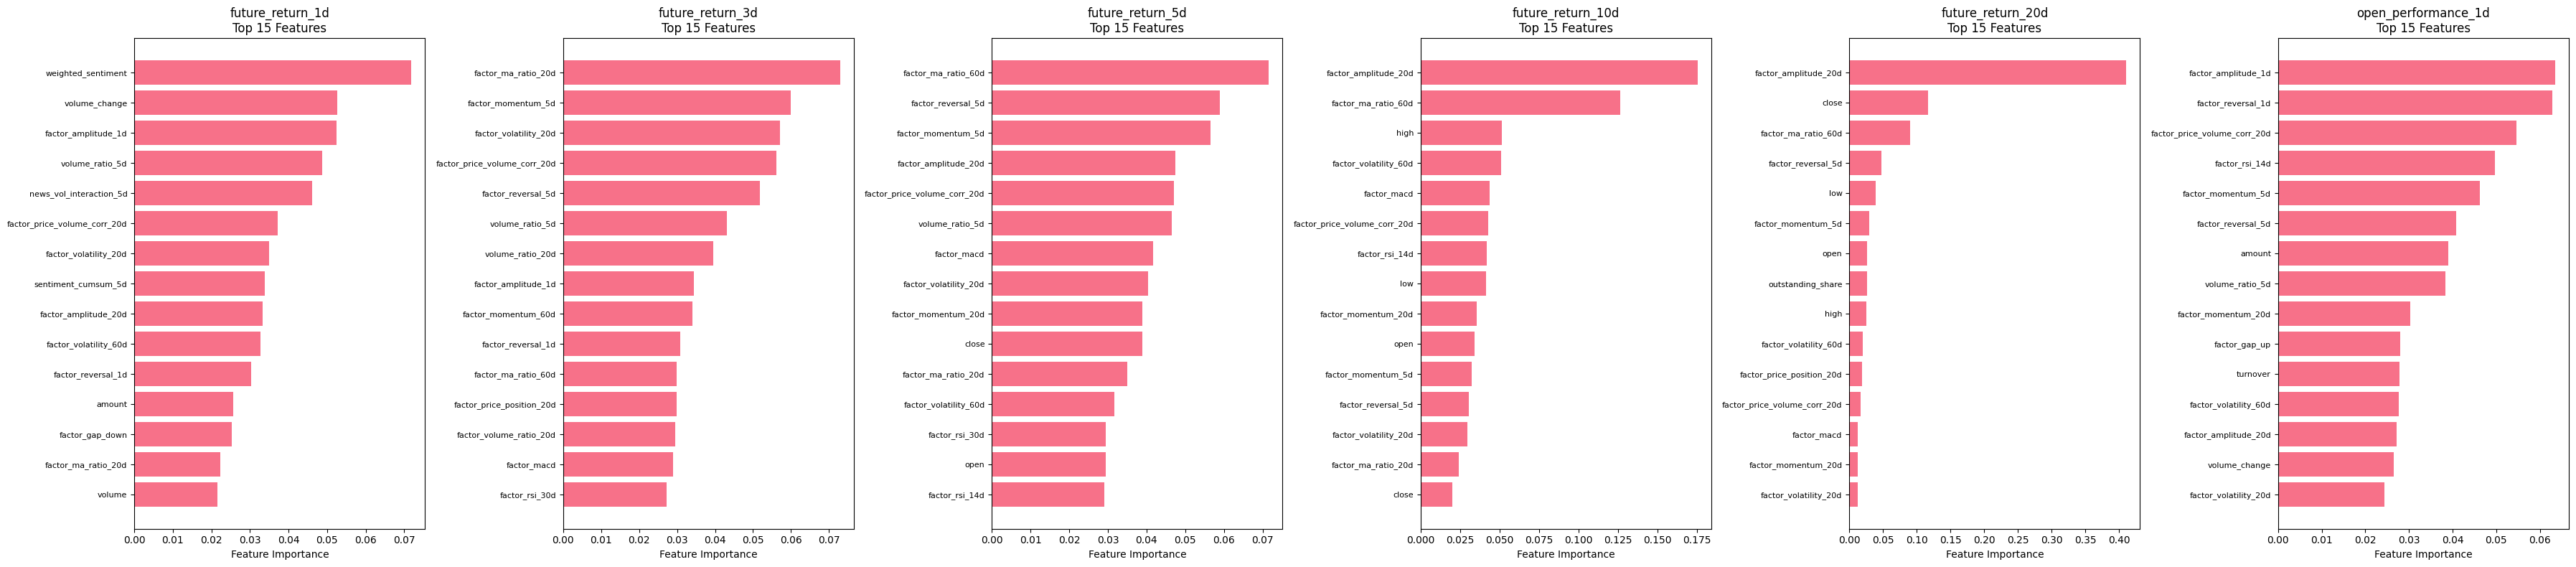

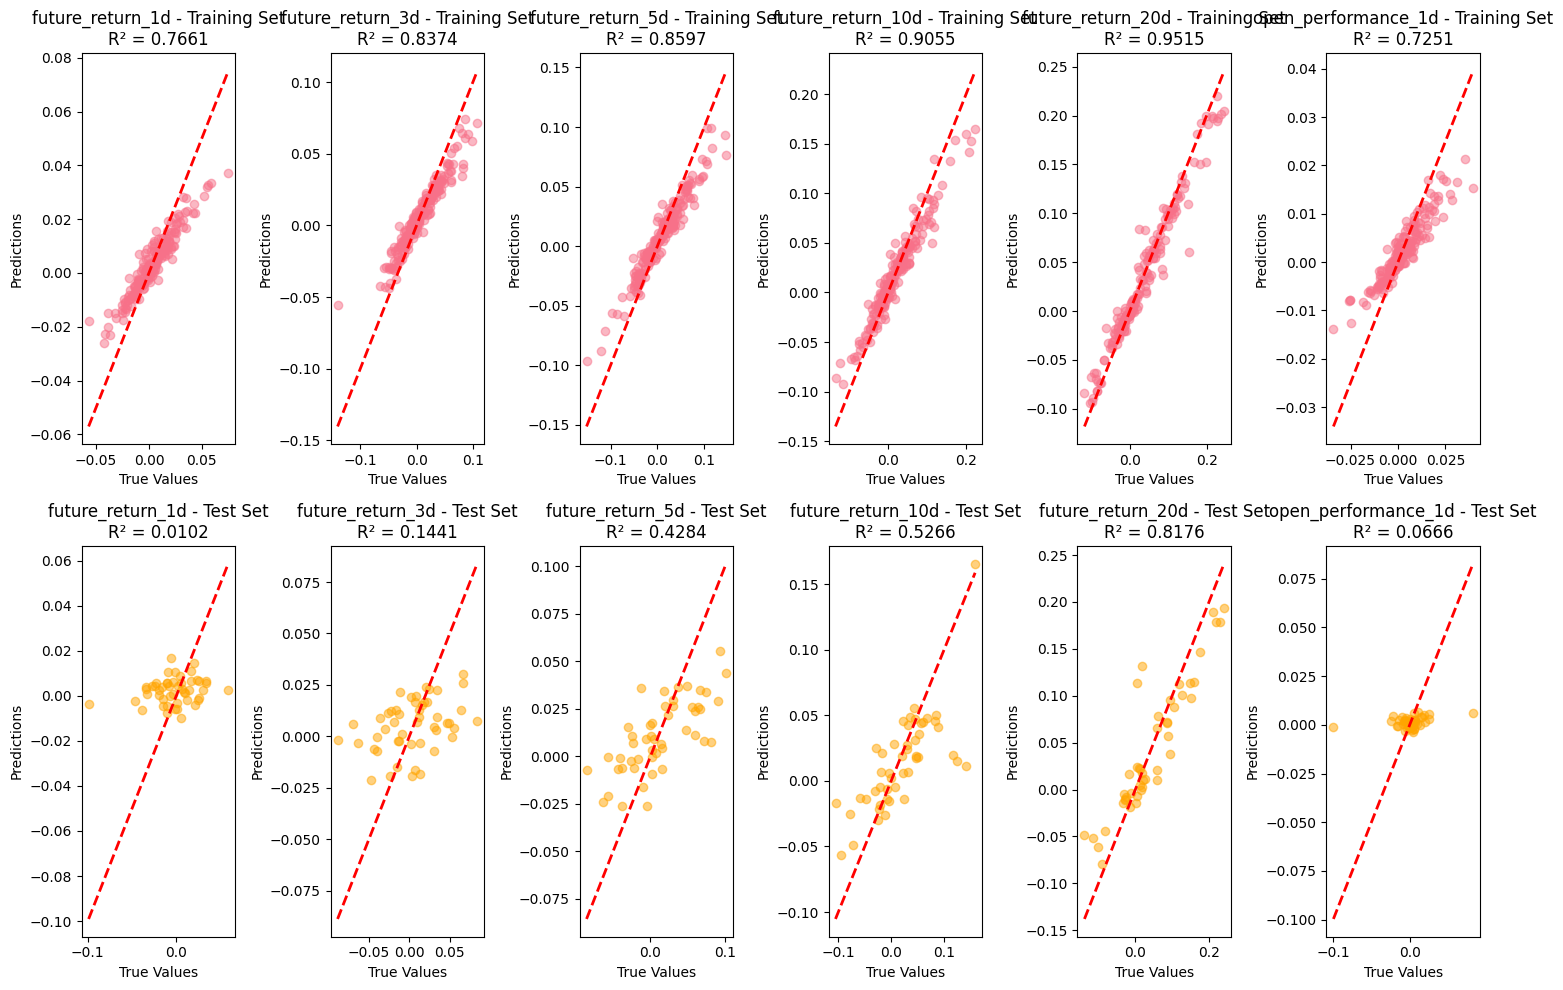


特征重要性汇总（所有目标变量平均）
                     feature  mean_importance  std_importance
        factor_amplitude_20d           0.1193          0.1540
         factor_ma_ratio_60d           0.0585          0.0451
factor_price_volume_corr_20d           0.0424          0.0145
          factor_reversal_5d           0.0414          0.0146
          factor_momentum_5d           0.0399          0.0173
                       close           0.0374          0.0403
       factor_volatility_20d           0.0331          0.0152
             volume_ratio_5d           0.0328          0.0184
       factor_volatility_60d           0.0312          0.0108
         factor_amplitude_1d           0.0305          0.0237
         factor_ma_ratio_20d           0.0305          0.0225
          factor_reversal_1d           0.0283          0.0195
              factor_rsi_14d           0.0278          0.0154
                 factor_macd           0.0269          0.0138
         factor_momentum_20d           0.0265      

In [30]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

class FutureReturnPredictor:
    def __init__(self, factor_results,future_return_columns):
        """
        初始化预测器
        
        Parameters:
        factor_results: DataFrame, 包含所有因子和目标变量的数据
        """
        self.factor_results = factor_results
        self.future_return_columns = future_return_columns
        self.models = {}
        self.feature_importance = {}
        self.predictions = {}
        self.metrics = {}
        
        # 定义特征列（排除目标变量和日期列）
        self.feature_columns = [col for col in factor_results.columns 
                               if col not in self.future_return_columns + ['date_x', 'date_y']]
    
    def preprocess_data(self):
        """
        数据预处理：处理缺失值和异常值
        """
        print("开始数据预处理...")
        
        # 复制数据
        self.data = self.factor_results.copy()
        
        # 显示数据基本信息
        print(f"原始数据形状: {self.data.shape}")
        print(f"特征数量: {len(self.feature_columns)}")
        print(f"目标变量: {self.future_return_columns}")
        
        # 处理缺失值
        missing_info = self.data[self.feature_columns + self.future_return_columns].isnull().sum()
        missing_features = missing_info[missing_info > 0]
        if len(missing_features) > 0:
            print(f"\n缺失值情况:\n{missing_features}")
            # 用中位数填充数值型特征的缺失值
            for col in self.feature_columns:
                if self.data[col].dtype in ['float64', 'int64']:
                    self.data[col].fillna(self.data[col].median(), inplace=True)
        
        # 处理异常值（使用IQR方法）
        print("\n处理异常值...")
        for col in self.feature_columns:
            if self.data[col].dtype in ['float64', 'int64']:
                Q1 = self.data[col].quantile(0.25)
                Q3 = self.data[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                
                # 将异常值替换为边界值
                self.data[col] = np.clip(self.data[col], lower_bound, upper_bound)
        
        print("数据预处理完成！")
        return self
    
    def train_models(self, test_size=0.2, random_state=42, optimize_params=False):
        """
        训练随机森林模型
        
        Parameters:
        test_size: 测试集比例
        random_state: 随机种子
        optimize_params: 是否进行参数优化
        """
        print("开始训练模型...")
        
        # 准备特征数据
        X = self.data[self.feature_columns]
        
        # 标准化特征（虽然随机森林对特征缩放不敏感，但可以提高某些情况下的性能）
        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=self.feature_columns, index=X.index)
        
        for target in self.future_return_columns:
            print(f"\n训练 {target} 预测模型...")
            
            # 准备目标变量
            y = self.data[target].dropna()
            X_target = X_scaled.loc[y.index]
            
            # 分割训练测试集
            X_train, X_test, y_train, y_test = train_test_split(
                X_target, y, test_size=test_size, random_state=random_state
            )
            
            # 设置基础参数
            base_params = {
                'n_estimators': 100,
                'max_depth': 10,
                'min_samples_split': 5,
                'min_samples_leaf': 2,
                'random_state': random_state,
                'n_jobs': -1
            }
            
            if optimize_params:
                # 参数优化
                param_grid = {
                    'n_estimators': [50, 100, 200],
                    'max_depth': [5, 10, 15, None],
                    'min_samples_split': [2, 5, 10],
                    'min_samples_leaf': [1, 2, 4]
                }
                
                rf = RandomForestRegressor(random_state=random_state, n_jobs=-1)
                grid_search = GridSearchCV(
                    rf, param_grid, cv=5, scoring='neg_mean_squared_error',
                    n_jobs=-1, verbose=0
                )
                grid_search.fit(X_train, y_train)
                best_model = grid_search.best_estimator_
                print(f"最佳参数: {grid_search.best_params_}")
            else:
                # 使用基础参数
                best_model = RandomForestRegressor(**base_params)
                best_model.fit(X_train, y_train)
            
            # 预测
            y_pred_train = best_model.predict(X_train)
            y_pred_test = best_model.predict(X_test)
            
            # 保存模型和预测结果
            self.models[target] = best_model
            self.predictions[target] = {
                'train': {'true': y_train, 'pred': y_pred_train},
                'test': {'true': y_test, 'pred': y_pred_test}
            }
            
            # 计算评估指标
            train_mse = mean_squared_error(y_train, y_pred_train)
            test_mse = mean_squared_error(y_test, y_pred_test)
            train_r2 = r2_score(y_train, y_pred_train)
            test_r2 = r2_score(y_test, y_pred_test)
            train_mae = mean_absolute_error(y_train, y_pred_train)
            test_mae = mean_absolute_error(y_test, y_pred_test)
            
            # 交叉验证
            cv_scores = cross_val_score(best_model, X_target, y, cv=5, scoring='r2')
            
            self.metrics[target] = {
                'train_mse': train_mse,
                'test_mse': test_mse,
                'train_r2': train_r2,
                'test_r2': test_r2,
                'train_mae': train_mae,
                'test_mae': test_mae,
                'cv_r2_mean': cv_scores.mean(),
                'cv_r2_std': cv_scores.std()
            }
            
            # 特征重要性
            self.feature_importance[target] = pd.DataFrame({
                'feature': self.feature_columns,
                'importance': best_model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            print(f"训练R²: {train_r2:.4f}, 测试R²: {test_r2:.4f}")
            print(f"交叉验证R²: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
        
        print("\n所有模型训练完成！")
        return self
    
    def evaluate_models(self):
        """
        评估模型性能
        """
        print("=" * 50)
        print("模型性能评估")
        print("=" * 50)
        
        results_df = []
        for target in self.future_return_columns:
            metrics = self.metrics[target]
            results_df.append({
                'Target': target,
                'Train_R2': metrics['train_r2'],
                'Test_R2': metrics['test_r2'],
                'CV_R2_Mean': metrics['cv_r2_mean'],
                'CV_R2_Std': metrics['cv_r2_std'],
                'Train_MSE': metrics['train_mse'],
                'Test_MSE': metrics['test_mse'],
                'Train_MAE': metrics['train_mae'],
                'Test_MAE': metrics['test_mae']
            })
        
        results_df = pd.DataFrame(results_df)
        print(results_df.to_string(index=False, float_format='%.4f'))
        
        return results_df
    
    def plot_feature_importance(self, top_n=15, figsize=(12, 8)):
        """
        绘制特征重要性图
        """
        n_targets = len(self.future_return_columns)
        fig, axes = plt.subplots(1, n_targets, figsize=(figsize[0]*n_targets//2, figsize[1]))
        if n_targets == 1:
            axes = [axes]
        
        for i, target in enumerate(self.future_return_columns):
            importance_df = self.feature_importance[target].head(top_n)
            
            axes[i].barh(range(len(importance_df)), importance_df['importance'])
            axes[i].set_yticks(range(len(importance_df)))
            axes[i].set_yticklabels(importance_df['feature'], fontsize=8)
            axes[i].set_xlabel('Feature Importance')
            axes[i].set_title(f'{target}\nTop {top_n} Features')
            axes[i].invert_yaxis()
        
        plt.tight_layout()
        plt.show()
    
    def plot_predictions(self, figsize=(15, 10)):
        """
        绘制预测结果对比图
        """
        n_targets = len(self.future_return_columns)
        fig, axes = plt.subplots(2, n_targets, figsize=figsize)
        if n_targets == 1:
            axes = axes.reshape(2, 1)
        
        for i, target in enumerate(self.future_return_columns):
            # 训练集预测
            train_true = self.predictions[target]['train']['true']
            train_pred = self.predictions[target]['train']['pred']
            
            axes[0, i].scatter(train_true, train_pred, alpha=0.5)
            axes[0, i].plot([train_true.min(), train_true.max()], 
                           [train_true.min(), train_true.max()], 'r--', lw=2)
            axes[0, i].set_xlabel('True Values')
            axes[0, i].set_ylabel('Predictions')
            axes[0, i].set_title(f'{target} - Training Set\nR² = {self.metrics[target]["train_r2"]:.4f}')
            
            # 测试集预测
            test_true = self.predictions[target]['test']['true']
            test_pred = self.predictions[target]['test']['pred']
            
            axes[1, i].scatter(test_true, test_pred, alpha=0.5, color='orange')
            axes[1, i].plot([test_true.min(), test_true.max()], 
                           [test_true.min(), test_true.max()], 'r--', lw=2)
            axes[1, i].set_xlabel('True Values')
            axes[1, i].set_ylabel('Predictions')
            axes[1, i].set_title(f'{target} - Test Set\nR² = {self.metrics[target]["test_r2"]:.4f}')
        
        plt.tight_layout()
        plt.show()
    
    def get_feature_importance_summary(self, top_n=10):
        """
        获取所有目标变量的特征重要性汇总
        """
        # 计算平均特征重要性
        all_importance = pd.DataFrame()
        for target in self.future_return_columns:
            importance_df = self.feature_importance[target][['feature', 'importance']].copy()
            importance_df.columns = ['feature', f'{target}_importance']
            if all_importance.empty:
                all_importance = importance_df
            else:
                all_importance = all_importance.merge(importance_df, on='feature', how='outer')
        
        # 计算平均重要性
        importance_cols = [col for col in all_importance.columns if col.endswith('_importance')]
        all_importance['mean_importance'] = all_importance[importance_cols].mean(axis=1)
        all_importance['std_importance'] = all_importance[importance_cols].std(axis=1)
        
        # 排序并返回前N个特征
        summary = all_importance.sort_values('mean_importance', ascending=False).head(top_n)
        return summary
    
    def predict_new_data(self, new_data):
        """
        对新数据进行预测
        
        Parameters:
        new_data: DataFrame, 新的特征数据
        """
        # 确保新数据包含所有特征列
        missing_features = set(self.feature_columns) - set(new_data.columns)
        if missing_features:
            raise ValueError(f"新数据缺少以下特征: {missing_features}")
        
        # 标准化新数据
        new_data_scaled = self.scaler.transform(new_data[self.feature_columns])
        new_data_scaled = pd.DataFrame(new_data_scaled, columns=self.feature_columns, index=new_data.index)
        
        # 预测
        predictions = {}
        for target in self.future_return_columns:
            predictions[target] = self.models[target].predict(new_data_scaled)
        
        return pd.DataFrame(predictions, index=new_data.index)

# 使用示例
if __name__ == "__main__":
    # 假设你的数据已经加载为 factor_results
    # factor_results = pd.read_csv('your_data.csv')
    
    # 初始化预测器
    predictor = FutureReturnPredictor(factor_results,future_return_columns=future_return_columns)
    
    # 数据预处理
    predictor.preprocess_data()
    
    # 训练模型（设置 optimize_params=True 进行参数优化，但会较慢）
    predictor.train_models(test_size=0.2, optimize_params=False)
    
    # 评估模型
    results = predictor.evaluate_models()
    
    # 绘制特征重要性
    predictor.plot_feature_importance(top_n=15)
    
    # 绘制预测结果
    predictor.plot_predictions()
    
    # 获取特征重要性汇总
    importance_summary = predictor.get_feature_importance_summary(top_n=20)
    print("\n" + "="*50)
    print("特征重要性汇总（所有目标变量平均）")
    print("="*50)
    print(importance_summary[['feature', 'mean_importance', 'std_importance']].to_string(index=False, float_format='%.4f'))
    
    # 对新数据进行预测（示例）
    # new_predictions = predictor.predict_new_data(new_data)
    # print(new_predictions)

In [19]:
factor_results.columns

Index(['open', 'high', 'low', 'close', 'volume', 'amount', 'outstanding_share',
       'turnover', 'factor_momentum_5d', 'factor_momentum_20d',
       'factor_momentum_60d', 'factor_reversal_1d', 'factor_reversal_5d',
       'factor_volatility_20d', 'factor_volatility_60d', 'factor_rsi_14d',
       'factor_rsi_30d', 'factor_ma_ratio_20d', 'factor_ma_ratio_60d',
       'factor_volume_ratio_20d', 'factor_price_volume_corr_20d',
       'factor_price_position_20d', 'factor_amplitude_1d',
       'factor_amplitude_20d', 'factor_gap_up', 'factor_gap_down',
       'factor_macd', 'future_return_1d', 'future_return_3d',
       'future_return_5d', 'future_return_10d', 'future_return_20d',
       'open_performance_1d', 'date_x', 'date_y', 'overall_score_mean',
       'overall_score_std', 'overall_score_count', 'overall_score_min',
       'overall_score_max', 'overall_score_sum', 'direct_impact_score_mean',
       'direct_impact_score_std', 'indirect_impact_score_mean',
       'indirect_impact_scor

In [20]:
factor_results['sentiment_<lambda>']

date
2024-09-20    中性偏正
2024-09-23      正面
2024-09-24       0
2024-09-25      正面
2024-09-26       0
              ... 
2025-09-17    中性偏正
2025-09-18       0
2025-09-19      正面
2025-09-22    强烈正面
2025-09-23       0
Name: sentiment_<lambda>, Length: 246, dtype: object

In [41]:
pd.set_option("display.max_rows", 200)
predictor.feature_importance['future_return_1d']

,feature,importance
43,weighted_sentiment,0.071814
58,volume_change,0.052531
22,factor_amplitude_1d,0.052363
56,volume_ratio_5d,0.048758
59,news_vol_interaction_5d,0.046076
20,factor_price_volume_corr_20d,0.037206
13,factor_volatility_20d,0.034876
54,sentiment_cumsum_5d,0.033810
23,factor_amplitude_20d,0.033229
14,factor_volatility_60d,0.032674
